In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle as pk


In [3]:
# Load your dataset (adjust the path if needed)
df = pd.read_csv('all_data.csv')
# Set the Date column as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [23]:
X = df.drop(columns=['gold_Close', 'gold_Open', 'gold_High', 'gold_Adj Close', 'gold_Low', 'gold_Volume', 'gold_price_to_predict'])
# Extract y
y = df['gold_price_to_predict']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Drop rows with NaN in X_train and y_train
X_train_dropped = X_train.dropna()
y_train_dropped = y_train[X_train_dropped.index]

# Drop rows with NaN in X_test and y_test
X_test_dropped = X_test.dropna()
y_test_dropped = y_test.loc[X_test_dropped.index]

# Ensure that y_test_dropped does not contain NaN values
X_test_dropped = X_test_dropped.dropna()
y_test_dropped = y_test_dropped.dropna()

# Check if indices still match after dropping NaNs
common_index = X_test_dropped.index.intersection(y_test_dropped.index)
X_test_dropped = X_test_dropped.loc[common_index]
y_test_dropped = y_test_dropped.loc[common_index]

print(y_train_dropped)

Date
2014-01-07    118.120003
2014-01-08    118.459999
2014-01-09    120.260002
2014-01-10    121.019997
2014-01-13    119.889999
                 ...    
2022-07-14    159.009995
2022-07-15    159.160004
2022-07-18    159.539993
2022-07-19    158.039993
2022-07-20    160.270004
Name: gold_price_to_predict, Length: 2290, dtype: float64


            Actual Gold Price
Date                         
2014-01-07         118.120003
2014-01-08         118.459999
2014-01-09         120.260002
2014-01-10         121.019997
2014-01-13         119.889999
...                       ...
2022-07-14         159.009995
2022-07-15         159.160004
2022-07-18         159.539993
2022-07-19         158.039993
2022-07-20         160.270004

[2290 rows x 1 columns]
TEST DF
            Actual Gold Price
Date                         
2022-07-21         160.669998
2022-07-22         160.229996
2022-07-25         160.039993
2022-07-26         161.669998
2022-07-27         163.639999
...                       ...
2024-08-23         232.759995
2024-08-26         233.389999
2024-08-27         231.750000
2024-08-28         232.949997
2024-08-29         231.289993

[573 rows x 1 columns]
            Predicted Gold Price
Date                            
2022-07-21            158.298629
2022-07-22            160.120828
2022-07-25            160.25910

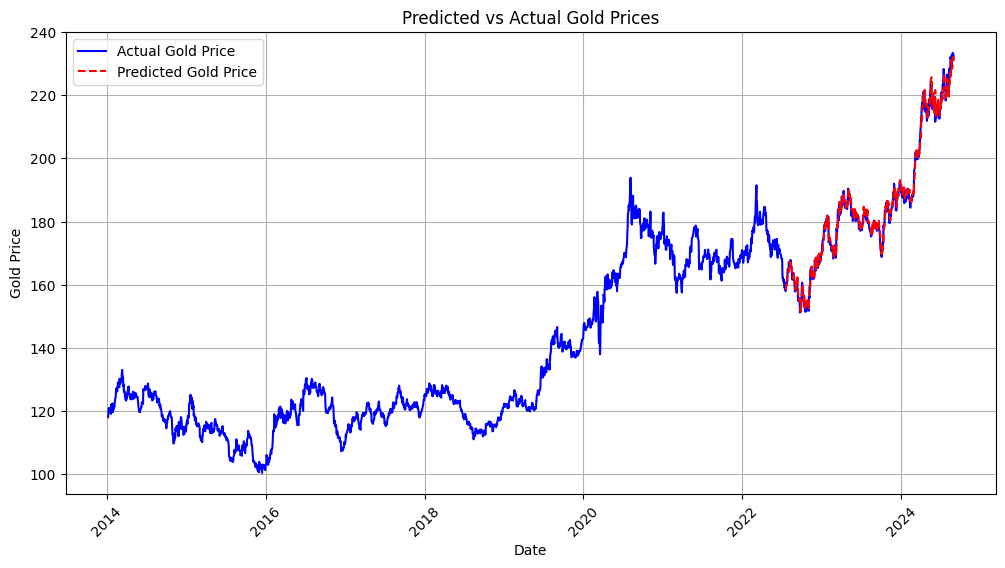

In [24]:
import pandas as pd

# Initialize a DataFrame for the training data
train_df = pd.DataFrame({'Actual Gold Price': y_train_dropped}, index=X_train_dropped.index)  # Use the index of X_train_dropped directly
print(train_df)
test_df = pd.DataFrame({'Actual Gold Price': y_test_dropped}, index=X_test_dropped.index)  # Use the index of X_test_dropped directly
print('TEST DF')
print(test_df)
# Initialize and train the model
model = LinearRegression()
model.fit(X_train_dropped, y_train_dropped)

# Make predictions on the test set
predictions = model.predict(X_test_dropped)

# Create a DataFrame for predictions
predictions_df = pd.DataFrame(predictions, index=y_test_dropped.index, columns=['Predicted Gold Price'])
print(predictions_df)
test_df = pd.DataFrame({'Actual Gold Price': y_test_dropped}, index=X_test_dropped.index)  # Use the index of X_test_dropped directly
combined_actual_df = pd.concat([train_df, test_df], axis=0)
print(combined_actual_df)
# Merge the concatenated DataFrame with predictions
combined_df = combined_actual_df.merge(predictions_df, left_index=True, right_index=True, how='outer')

# Check the combined DataFrame
print(combined_df)
print("Combined DataFrame shape:", combined_df.shape)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Actual Gold Price'], label='Actual Gold Price', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted Gold Price'], label='Predicted Gold Price', color='red', linestyle='--')
plt.title('Predicted vs Actual Gold Prices')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.xticks(rotation=45)  # Rotat
# e x-axis labels for better readability
plt.grid()
plt.show()


Root Mean Square Error: 2.06
Mean Absolute Error: 1.56
R² Score: 0.99


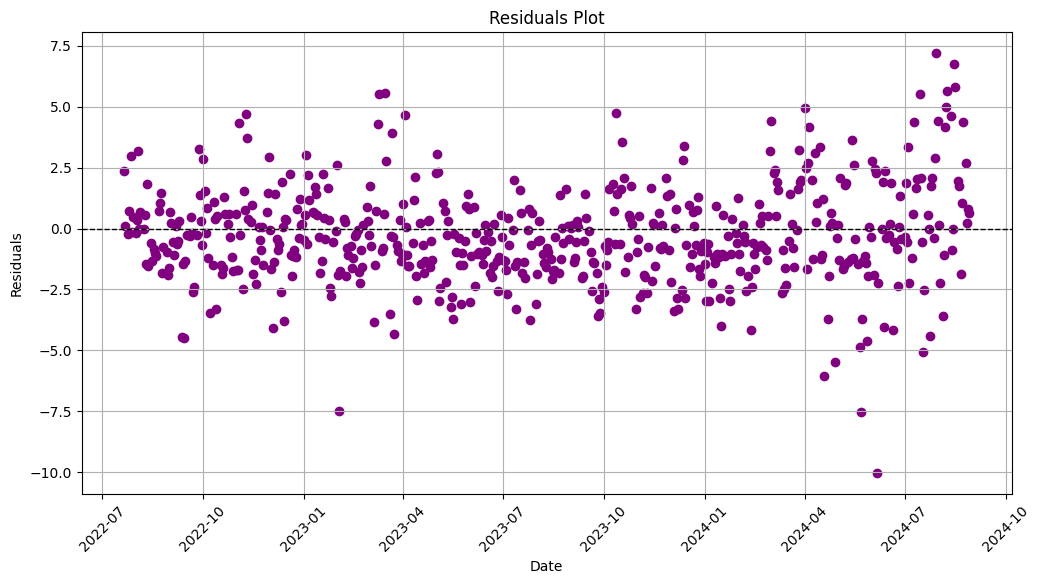

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_dropped, predictions))
mae = mean_absolute_error(y_test_dropped, predictions)
r2 = r2_score(y_test_dropped, predictions)

print(f"Root Mean Square Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot residuals
residuals = y_test_dropped - predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test_dropped.index, residuals, color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [7]:
import statsmodels.api as sm

# Add a constant term to the model (intercept)
X_train_dropped = sm.add_constant(X_train_dropped)
X_test_dropped = sm.add_constant(X_test_dropped)

# Fit the model using statsmodels OLS (Ordinary Least Squares)
model = sm.OLS(y_train_dropped, X_train_dropped).fit()

# Print out the summary of the model
print(model.summary())


                              OLS Regression Results                             
Dep. Variable:     gold_price_to_predict   R-squared:                       0.997
Model:                               OLS   Adj. R-squared:                  0.997
Method:                    Least Squares   F-statistic:                 2.728e+04
Date:                   Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                           16:32:05   Log-Likelihood:                -3681.2
No. Observations:                   2290   AIC:                             7428.
Df Residuals:                       2257   BIC:                             7618.
Df Model:                             32                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

/Library/Python/3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.355e+02, tolerance: 1.295e+02
  model = cd_fast.enet_coordinate_descent(


Root Mean Square Error: 1.7319328543930577
Mean Absolute Error: 1.2914866268938896
Lasso Coefficients:
gold_Open          5.343339e+00
gold_High          7.775247e+00
gold_Low           3.320779e+00
gold_Close         7.181863e+00
gold_Adj Close     2.908571e-13
sp500_Low          3.764415e-02
silver_Change %    3.831126e-02
dtype: float64


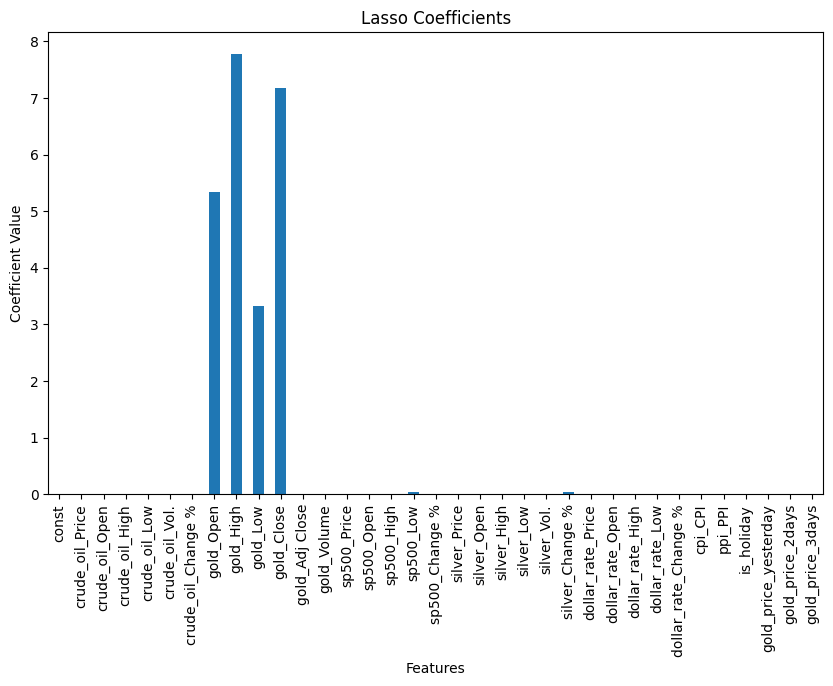

In [10]:
# Lasso Regression - Feature Selection
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming you have already created X_train_dropped, X_test_dropped, y_train_dropped, y_test_dropped

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dropped)
X_test_scaled = scaler.transform(X_test_dropped)

# Initialize the Lasso model with a chosen alpha (regularization strength)
alpha = 0.1  # You may need to adjust this value
lasso_model = Lasso(alpha=alpha)

# Fit the Lasso model
lasso_model.fit(X_train_scaled, y_train_dropped)

# Predictions
y_pred = lasso_model.predict(X_test_scaled)

# Calculate and print evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_dropped, y_pred))
mae = mean_absolute_error(y_test_dropped, y_pred)

print(f"Root Mean Square Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

# Get the coefficients and the corresponding feature names
coef = pd.Series(lasso_model.coef_, index=X_train_dropped.columns)
print("Lasso Coefficients:")
print(coef[coef != 0])  # Print only significant features (non-zero coefficients)

# Optional: Plot the coefficients
plt.figure(figsize=(10, 6))
coef.plot(kind='bar')
plt.title('Lasso Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()


In [9]:
X_train_dropped = X_train.dropna()
y_train_dropped = y_train[X_train_dropped.index]

# Drop rows with NaN in X_test and y_test
X_test_dropped = X_test.dropna()
y_test_dropped = y_test.loc[X_test_dropped.index]  # Drop NaNs based on indices in X_test_dropped

# Ensure that y_test_dropped does not contain NaN values
X_test_dropped = X_test_dropped.dropna()
y_test_dropped = y_test_dropped.dropna()

# Check if indices still match after dropping NaNs
common_index = X_test_dropped.index.intersection(y_test_dropped.index)
X_test_dropped = X_test_dropped.loc[common_index]
y_test_dropped = y_test_dropped.loc[common_index]
# Initialize and train the model
model = LinearRegression()
model.fit(X_train_dropped, y_train_dropped)

# Predict on test data
y_pred = model.predict(X_test_dropped)
pred_index = X_test_dropped.index

# Create a DataFrame for predictions
linear_reg_predictions_df = pd.DataFrame(y_pred, index=pred_index, columns=['Predictions'])
# Assuming test_data is the DataFrame with actual values and it has the same index as X_test_dropped
# Combine predictions and actual test data
test_data = y_test_dropped.to_frame()  # Ensure test_data is a DataFrame
linear_reg_predictions_df = test_data.join(linear_reg_predictions_df)
linear_reg_predictions_df.index = linear_reg_predictions_df.index + pd.DateOffset(days=1)

# Evaluate the model
mse = mean_squared_error(y_test_dropped, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_dropped, y_pred)
mae = mean_absolute_error(y_test_dropped, y_pred)

print("Linear Regression Model Summary")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Linear Regression Model Summary
Intercept: 0.8942773132619095
Coefficients: [-1.27783821e-01 -9.97125887e-02  1.64038437e-01  6.44011822e-02
 -2.11175129e-07  1.20108213e-02  1.77980622e-02 -1.33847945e-01
  9.26416496e-02  5.20095931e-01  5.20095931e-01  7.48899973e-09
  1.23358993e-03 -1.85111747e-04 -1.62195633e-03  7.58639416e-04
 -5.72889832e-03 -1.61241491e-01  1.52980023e-01  2.70671242e-01
 -3.10323340e-01 -3.37250993e-06  2.13729826e-02  1.40609082e-01
 -2.80037533e-01  3.76724489e-02  8.53044698e-02 -1.46524877e-01
  1.65354358e-02 -1.28223964e-02  0.00000000e+00 -4.28119139e-02
  2.68295478e-02 -3.45463634e-03]
Mean Squared Error (MSE): 2.674395522565233
Mean Absolute Error (MAE): 1.200884343136175
Root Mean Squared Error (RMSE): 1.635357918794914
R-squared (R2): 0.9934277765317894


In [10]:
with open('modelResults/linear_reg_predictions_df', 'wb') as file:
    # Serialize the object and write it to the file
    pkl.dump(linear_reg_predictions_df, file)

In [ ]:
import pandas as pd

# Assuming `gold_prices` is your DataFrame with actual prices and `predictions` is a Series of predicted prices
gold_prices['Returns'] = gold_prices['gold_price'].pct_change()  # Actual returns
predictions['Returns'] = predictions.pct_change()  # Predicted returns
